# 多クラスのロジスティック回帰で手書き文字を認識

# 0. 序： なぜ、ロジスティック回帰？

線形回帰の理解からディープラーニングの理解に至る、中間段階として。

* 線形回帰 (直線フィット）
  * 最尤法による誤差関数 (と最小二乗法による誤差関数は実は同じ。）
  * 確率モデル


* ロジステック回帰 <-- 今、ここ
  * 最尤法によるパラメーター推定という点で、線形回帰と同じ
  * 確率モデルという考え方を使うと、回帰モデルは分類にも使える。
  * 複数のクラスを分類するための拡張


* ディープラーニングの基本 <-- 次のノート
  * 最尤法によるパラメーター推定という点で、線形回帰と同じ
  * 回帰モデルの入力と出力と間に、隠れ層を追加。層を深くする。（だから"深層"学習）

## 0.1 TensorFlow を動かす準備

In [1]:
import tensorflow as tf

from math import *
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# 1. 方法論： ロジステック回帰

## 1. 1 基本は線形回帰と同じ

線形回帰のモデル式
$$ f(x_1, \ldots, x_n) = w_0 + x_1 w_1 + \ldots + x_n w_n$$  
をシグモイド関数
$$ \sigma(x ; w) = \frac{1}{ 1 + e^{- x} }  $$ 
を用いて、
$$ P( x_1, \ldots, x_n ) = \sigma( f(x_1, \ldots, x_n) ) $$
のように拡張する。

この関数$P$は、独立変数の組${( x_1, \ldots, x_n)}$に対応する事象についての確率であると、考える。


## 1.2 ここでも最尤法でモデルパラメーターを推定する

与えられたデータで、

誤差関数は次のようにする。

$$ E = \sum_i  $$


## TensorFlow を動かす準備

モジュールをインポートする。

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data

# MNISTデータセットをダウンロード

MNISTのデータセットをダウンロードして、mnistオブジェクトに格納する。

In [2]:
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


一般に、機械学習のためのデータには、３つのデータセット、学習用、検証用、テスト用が用意されている。

In [3]:
print "traing data: \t\t", len( mnist.train.images),"images", len(mnist.train.labels), "labels"
print "validation data:\t", len( mnist.validation.images),"images", len(mnist.validation.labels), "labels"
print "test data: \t\t", len( mnist.test.images),"images", len(mnist.test.labels), "labels"

traing data: 		55000 images 55000 labels
validation data:	5000 images 5000 labels
test data: 		10000 images 10000 labels


学習はモデルパラメーターを最適化するために、検証は複数のモデルから最良のモデルを選ぶために、テストは未知データに対するモデルの予測精度を見積もるために、行われる。
ここでは、モデルは１種類だけを作るので、学習とテストだけを行う。
 
それぞれのデータセットには画像とラベルが同数だけ含まれる。

トレーニングセットから、10個分のデータを取り出して、画像データとラベルを別々の変数に格納する。

In [4]:
images, labels = mnist.train.next_batch(10)

 画像データを実際の画像として表示してみる。

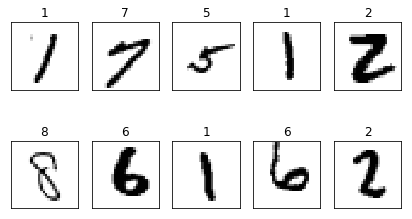

In [5]:
fig = plt.figure(figsize=(7,4))
for c, (image, label) in enumerate(zip(images, labels)):
    subplot = fig.add_subplot(2,5,c+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('%d' % np.argmax(label))
    subplot.imshow(image.reshape((28,28)), vmin=0, vmax=1,
                   cmap=plt.cm.gray_r, interpolation="nearest")

In [6]:
print [ np.argmax(l) for l in labels[ range(10)] ]

[1, 7, 5, 1, 2, 8, 6, 1, 6, 2]


# 分類するためのモデルを作成

画像データ$x_i$が数字k に分類される確率 $P_k(\bf x_i)$ の行列 $P$ を以下のように定義する。行列$P$は$P_k(\bf x_i)$ をi行目、k列目の要素としてまとめたものである。（$i = 1, \ldots, M .$　Mはデータの個数、$ k = 1, \ldots , K .$ K は分類クラスの個数、ここでは $K=10$）  

In [8]:
x = tf.placeholder(tf.float32, [None, 784])
w = tf.Variable(tf.zeros([784, 10]))
w0 = tf.Variable(tf.zeros([10]))
f = tf.matmul(x, w) + w0
p = tf.nn.softmax(f)

ここで、画像データ $\bf x_i$ は、M個のピクセルに対応して、
$$ {\bf x_j} = ( x_{i1}\, x_{i2}\, \ldots x_{iM} )$$
のように同じ数の成分を持つベクトルであり、これらN個の画像データを、
$$ X^t = ( {\bf x_1\, x_2 \, \ldots x_N} ) $$
のように行列としてまとめている。

分類確率を計算するために、まず、画像データ$\bf x_i$とモデルパラメータ$w_{ik}$ から次のような一次関数$f_k(\bf x_i)$ を計算する。
$$ f_k({\bf x_i}) = w_{0j} + x_{i1} w_{1j} + x_{i2} w_{2j} + \ldots + x_{iM} w_{Mj}$$
この$f_j(\bf x_i)$も行列$P$と同じように、行列$F$のi行目、j列目の要素であるとして、まとめられている。

$P_j(\bf x_i)$はソフトマックス関数を使って、次のように計算される。
$$ P_k(\bf x_i) = \frac{ \exp( f_k({\bf x_i})) }{\sum_{k'=1}^{K} exp( f_k'({\bf x_i})) }  $$

誤差関数は


乱数のシードを設定

In [7]:
np.random.seed(20160604)